In [1]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ks_2samp, gaussian_kde, spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Configuration

In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Data paths - UPDATE THESE FOR YOUR ENVIRONMENT
REAL_DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc04_updates_20251116_extracted_discovered.csv'
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results/Copula_v3/'

# Generation settings
N_SYNTHETIC = 60000  # Number of samples to generate
RANDOM_STATE = 42

# All 27 BGP features
ALL_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_avg', 'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases', 'rare_ases_avg',
    'nadas', 'flaps'
]

# Integer features (must be rounded)
INTEGER_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases', 'nadas', 'flaps'
]

# Zero-inflated features (high proportion of zeros)
ZERO_INFLATED_FEATURES = ['flaps', 'nadas', 'imp_wd', 'number_rare_ases']

# Heavy-tailed features (need special handling)
HEAVY_TAILED_FEATURES = ['unique_as_path_max', 'edit_distance_max', 'rare_ases_avg', 'as_path_max']

print("Configuration loaded!")
print(f"  Total features: {len(ALL_FEATURES)}")
print(f"  Integer features: {len(INTEGER_FEATURES)}")
print(f"  Zero-inflated features: {len(ZERO_INFLATED_FEATURES)}")
print(f"  Heavy-tailed features: {len(HEAVY_TAILED_FEATURES)}")

Configuration loaded!
  Total features: 27
  Integer features: 25
  Zero-inflated features: 4
  Heavy-tailed features: 4


## 2. Load Real Data

In [3]:
# =============================================================================
# LOAD REAL DATA
# =============================================================================

try:
    df_real = pd.read_csv(REAL_DATA_PATH)
    print(f"Loaded real data: {df_real.shape}")
except FileNotFoundError:
    print(f"File not found: {REAL_DATA_PATH}")
    print("Please update REAL_DATA_PATH to your data location")
    raise

# Filter to feature columns only
available_features = [f for f in ALL_FEATURES if f in df_real.columns]
X_real = df_real[available_features].copy()

print(f"\nUsing {len(available_features)} features")
print(f"Real data shape: {X_real.shape}")
print(f"\nFeature statistics:")
X_real.describe().T[['mean', 'std', 'min', 'max']]

Loaded real data: (86387, 38)

Using 27 features
Real data shape: (86387, 27)

Feature statistics:


,mean,std,min,max
announcements,182.400141,313.207475,0.0,12661.00
withdrawals,15.683124,60.897714,0.0,2454.00
nlri_ann,182.400141,313.207475,0.0,12661.00
dups,7.361316,26.892458,0.0,947.00
origin_0,134.409251,261.810161,0.0,11844.00
origin_2,47.856796,129.982329,0.0,3194.00
origin_changes,7.228252,22.419876,0.0,780.00
imp_wd,12.734752,38.065959,0.0,962.00
imp_wd_spath,5.018070,24.338445,0.0,815.00
imp_wd_dpath,7.716682,26.143583,0.0,961.00


## 3. Analyze Feature Characteristics

In [4]:
# =============================================================================
# ANALYZE FEATURE CHARACTERISTICS
# =============================================================================

def analyze_features(X):
    """Analyze each feature's characteristics for optimal copula configuration."""
    analysis = []
    
    for col in X.columns:
        vals = X[col].dropna().values
        
        # Basic stats
        zero_ratio = (vals == 0).mean()
        unique_ratio = len(np.unique(vals)) / len(vals)
        skewness = stats.skew(vals)
        kurtosis = stats.kurtosis(vals)
        
        # Determine characteristics
        is_zero_inflated = zero_ratio > 0.2
        is_heavy_tailed = kurtosis > 3 or skewness > 2
        is_discrete = unique_ratio < 0.1 or col in INTEGER_FEATURES
        
        analysis.append({
            'feature': col,
            'zero_ratio': zero_ratio,
            'unique_ratio': unique_ratio,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'is_zero_inflated': is_zero_inflated,
            'is_heavy_tailed': is_heavy_tailed,
            'is_discrete': is_discrete
        })
    
    return pd.DataFrame(analysis)

feature_analysis = analyze_features(X_real)

print("Feature Analysis Summary:")
print(f"  Zero-inflated features: {feature_analysis['is_zero_inflated'].sum()}")
print(f"  Heavy-tailed features: {feature_analysis['is_heavy_tailed'].sum()}")
print(f"  Discrete features: {feature_analysis['is_discrete'].sum()}")

# Show problematic features
print("\nFeatures needing special handling:")
problematic = feature_analysis[
    feature_analysis['is_zero_inflated'] | feature_analysis['is_heavy_tailed']
][['feature', 'zero_ratio', 'skewness', 'kurtosis']]
print(problematic.to_string(index=False))

Feature Analysis Summary:
  Zero-inflated features: 13
  Heavy-tailed features: 26
  Discrete features: 25

Features needing special handling:
                    feature  zero_ratio  skewness    kurtosis
              announcements    0.000058  7.510413  171.516823
                withdrawals    0.180062  9.554162  144.786311
                   nlri_ann    0.000058  7.510413  171.516823
                       dups    0.395129  9.036478  124.580691
                   origin_0    0.003762  9.372149  270.234454
                   origin_2    0.009041  7.823882   86.728380
             origin_changes    0.189670 13.058090  272.191731
                     imp_wd    0.115029  8.984847  120.827490
               imp_wd_spath    0.488546 10.634637  148.892329
               imp_wd_dpath    0.206142 15.155593  348.039437
                as_path_max    0.000058  8.352911  468.814013
          edit_distance_avg    0.062787  1.407019    9.667475
          edit_distance_max    0.062787 36.730419 4

## 4. Enhanced Copula Implementation

In [5]:
# =============================================================================
# HYBRID CORRELATION (PEARSON + SPEARMAN)
# =============================================================================

def compute_hybrid_correlation(X, pearson_weight=0.3, spearman_weight=0.7):
    """
    Compute hybrid correlation matrix using both Pearson and Spearman.
    
    Why use both?
    - Pearson: Captures linear relationships, sensitive to outliers
    - Spearman: Captures monotonic (non-linear) relationships, robust to outliers
    
    For BGP data with heavy tails and non-linear relationships,
    Spearman should have higher weight.
    
    Parameters:
    -----------
    X : DataFrame - Input data
    pearson_weight : float - Weight for Pearson correlation (default 0.3)
    spearman_weight : float - Weight for Spearman correlation (default 0.7)
    
    Returns:
    --------
    numpy.ndarray - Hybrid correlation matrix
    """
    assert abs(pearson_weight + spearman_weight - 1.0) < 1e-6, "Weights must sum to 1"
    
    # Compute Pearson correlation
    pearson_corr = X.corr(method='pearson').values
    
    # Compute Spearman correlation
    spearman_corr = X.corr(method='spearman').values
    
    # Handle NaN values
    pearson_corr = np.nan_to_num(pearson_corr, nan=0.0)
    spearman_corr = np.nan_to_num(spearman_corr, nan=0.0)
    
    # Weighted combination
    hybrid_corr = pearson_weight * pearson_corr + spearman_weight * spearman_corr
    
    # Ensure diagonal is 1
    np.fill_diagonal(hybrid_corr, 1.0)
    
    # Ensure positive definiteness
    eigvals, eigvecs = np.linalg.eigh(hybrid_corr)
    eigvals = np.maximum(eigvals, 1e-6)
    hybrid_corr = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    # Normalize to correlation matrix
    d = np.sqrt(np.diag(hybrid_corr))
    hybrid_corr = hybrid_corr / np.outer(d, d)
    np.fill_diagonal(hybrid_corr, 1.0)
    
    return hybrid_corr

print("Hybrid correlation function defined!")

Hybrid correlation function defined!


In [6]:
# =============================================================================
# MARGINAL ESTIMATION (KDE + EMPIRICAL)
# =============================================================================

class MarginalEstimator:
    """
    Estimates marginal distributions using adaptive methods.
    
    - KDE for continuous features with many unique values
    - Empirical CDF for discrete/low-cardinality features
    - Special handling for zero-inflated features
    """
    
    def __init__(self, use_kde=True, handle_zeros=True, log_transform_heavy=True, kde_bandwidth_factor=1.0):
        self.use_kde = use_kde
        self.handle_zeros = handle_zeros
        self.log_transform_heavy = log_transform_heavy
        self.kde_bandwidth_factor = kde_bandwidth_factor  # <1 = narrower/sharper, >1 = wider/smoother
        self.marginals = {}
    
    def fit(self, X, feature_analysis=None):
        """
        Fit marginal distributions for each feature.
        """
        self.feature_names = X.columns.tolist()
        self.n_features = len(self.feature_names)
        
        for col in self.feature_names:
            vals = X[col].values.copy()
            
            # Analyze feature
            zero_ratio = (vals == 0).mean()
            n_unique = len(np.unique(vals))
            is_heavy = col in HEAVY_TAILED_FEATURES or (vals.max() > 100 and stats.skew(vals) > 2)
            
            marginal_info = {
                'zero_ratio': zero_ratio,
                'is_zero_inflated': zero_ratio > 0.2,
                'is_heavy_tailed': is_heavy,
                'is_integer': col in INTEGER_FEATURES,
                'original_values': vals,
                'sorted_values': np.sort(vals),
                'method': 'empirical'  # default
            }
            
            # Choose estimation method
            if self.use_kde and n_unique > 20 and not marginal_info['is_integer']:
                try:
                    # Apply bandwidth factor to Scott's rule
                    bw_method = lambda obj: obj.scotts_factor() * self.kde_bandwidth_factor
                    
                    if is_heavy and self.log_transform_heavy and vals.min() >= 0:
                        # Log-transform for heavy-tailed
                        log_vals = np.log1p(vals)
                        kde = gaussian_kde(log_vals, bw_method=bw_method)
                        marginal_info['kde'] = kde
                        marginal_info['method'] = 'kde_log'
                        marginal_info['log_sorted'] = np.sort(log_vals)
                    else:
                        kde = gaussian_kde(vals, bw_method=bw_method)
                        marginal_info['kde'] = kde
                        marginal_info['method'] = 'kde'
                except:
                    pass  # Fall back to empirical
            
            self.marginals[col] = marginal_info
        
        return self
    
    def transform_to_uniform(self, X):
        """
        Transform data to uniform [0,1] using fitted marginals.
        """
        n_samples = len(X)
        uniform_data = np.zeros((n_samples, self.n_features))
        
        for i, col in enumerate(self.feature_names):
            vals = X[col].values
            info = self.marginals[col]
            
            # Use empirical CDF (rank-based)
            ranks = stats.rankdata(vals, method='average')
            uniform_data[:, i] = np.clip(ranks / (n_samples + 1), 0.001, 0.999)
        
        return uniform_data
    
    def inverse_transform(self, uniform_data, n_samples):
        """
        Transform uniform samples back to original scale.
        """
        synthetic_data = np.zeros((n_samples, self.n_features))
        
        for i, col in enumerate(self.feature_names):
            info = self.marginals[col]
            u = uniform_data[:, i]
            
            if self.handle_zeros and info['is_zero_inflated']:
                # Handle zero-inflated features
                synthetic_data[:, i] = self._inverse_zero_inflated(u, info)
            else:
                # Standard inverse CDF
                synthetic_data[:, i] = self._inverse_standard(u, info)
            
            # Enforce non-negativity
            synthetic_data[:, i] = np.maximum(0, synthetic_data[:, i])
            
            # Enforce integer constraint
            if info['is_integer']:
                synthetic_data[:, i] = np.round(synthetic_data[:, i])
        
        return synthetic_data
    
    def _inverse_standard(self, u, info):
        """Standard inverse CDF using quantile function."""
        sorted_vals = info['sorted_values']
        indices = (u * len(sorted_vals)).astype(int)
        indices = np.clip(indices, 0, len(sorted_vals) - 1)
        return sorted_vals[indices]
    
    def _inverse_zero_inflated(self, u, info):
        """Inverse CDF for zero-inflated features."""
        zero_ratio = info['zero_ratio']
        original = info['original_values']
        
        result = np.zeros(len(u))
        
        # Samples with u < zero_ratio become zeros
        is_zero = u < zero_ratio
        
        # For non-zero samples, map to non-zero distribution
        non_zero_vals = original[original > 0]
        if len(non_zero_vals) > 0:
            # Scale u to [0,1] for non-zero part
            scaled_u = (u[~is_zero] - zero_ratio) / (1 - zero_ratio + 1e-10)
            scaled_u = np.clip(scaled_u, 0, 1)
            
            sorted_non_zero = np.sort(non_zero_vals)
            indices = (scaled_u * len(sorted_non_zero)).astype(int)
            indices = np.clip(indices, 0, len(sorted_non_zero) - 1)
            result[~is_zero] = sorted_non_zero[indices]
        
        return result

print("Marginal Estimator class defined (with bandwidth tuning)!")

Marginal Estimator class defined (with bandwidth tuning)!


In [7]:
# =============================================================================
# ENHANCED COPULA GENERATOR
# =============================================================================

class EnhancedCopulaGenerator:
    """
    Enhanced Copula Generator with multiple improvements:
    
    1. Hybrid correlation (Pearson + Spearman)
    2. Adaptive marginal estimation (KDE + Empirical)
    3. Zero-inflation handling
    4. t-Copula option for heavy tails
    5. Built-in constraint enforcement
    6. KDE bandwidth tuning for fine-grained control
    """
    
    def __init__(self, 
                 copula_type='gaussian',  # 'gaussian' or 't'
                 t_df=5,                  # degrees of freedom for t-copula
                 pearson_weight=0.3,      # weight for Pearson correlation
                 spearman_weight=0.7,     # weight for Spearman correlation
                 use_kde_marginals=True,
                 kde_bandwidth_factor=1.0,  # <1 = narrower/sharper, >1 = wider/smoother
                 handle_zeros=True,
                 random_state=42):
        
        self.copula_type = copula_type
        self.t_df = t_df
        self.pearson_weight = pearson_weight
        self.spearman_weight = spearman_weight
        self.use_kde_marginals = use_kde_marginals
        self.kde_bandwidth_factor = kde_bandwidth_factor
        self.handle_zeros = handle_zeros
        self.random_state = random_state
        
        self.marginal_estimator = None
        self.correlation_matrix = None
        self.cholesky_L = None
    
    def fit(self, X):
        """
        Fit the copula model to real data.
        """
        print("Fitting Enhanced Copula...")
        print(f"  Configuration:")
        print(f"    - Copula type: {self.copula_type}" + 
              (f" (df={self.t_df})" if self.copula_type == 't' else ""))
        print(f"    - Correlation: {self.pearson_weight:.0%} Pearson + {self.spearman_weight:.0%} Spearman")
        print(f"    - Marginals: {'KDE' if self.use_kde_marginals else 'Empirical'}" +
              (f" (bw={self.kde_bandwidth_factor}x)" if self.use_kde_marginals else ""))
        print(f"    - Zero handling: {self.handle_zeros}")
        
        self.feature_names = X.columns.tolist()
        self.n_features = len(self.feature_names)
        
        # Step 1: Fit marginal distributions
        print("\n  [1/3] Fitting marginal distributions...")
        self.marginal_estimator = MarginalEstimator(
            use_kde=self.use_kde_marginals,
            handle_zeros=self.handle_zeros,
            kde_bandwidth_factor=self.kde_bandwidth_factor
        )
        self.marginal_estimator.fit(X)
        
        # Step 2: Compute hybrid correlation matrix
        print("  [2/3] Computing hybrid correlation matrix...")
        self.correlation_matrix = compute_hybrid_correlation(
            X, 
            pearson_weight=self.pearson_weight,
            spearman_weight=self.spearman_weight
        )
        
        # Step 3: Compute Cholesky decomposition
        print("  [3/3] Computing Cholesky decomposition...")
        try:
            self.cholesky_L = np.linalg.cholesky(self.correlation_matrix)
        except np.linalg.LinAlgError:
            # Add regularization if needed
            self.correlation_matrix += 0.01 * np.eye(self.n_features)
            self.cholesky_L = np.linalg.cholesky(self.correlation_matrix)
        
        print("  Fitting complete!")
        return self
    
    def generate(self, n_samples):
        """
        Generate synthetic samples.
        """
        np.random.seed(self.random_state)
        
        print(f"\nGenerating {n_samples} samples...")
        
        # Step 1: Generate independent samples in copula space
        if self.copula_type == 'gaussian':
            independent_samples = np.random.randn(n_samples, self.n_features)
        else:  # t-copula
            # Multivariate t: Z / sqrt(chi2/df)
            chi2_samples = np.random.chisquare(self.t_df, n_samples) / self.t_df
            independent_samples = np.random.randn(n_samples, self.n_features)
            independent_samples = independent_samples / np.sqrt(chi2_samples)[:, np.newaxis]
        
        # Step 2: Induce correlation via Cholesky
        correlated_samples = independent_samples @ self.cholesky_L.T
        
        # Step 3: Transform to uniform via CDF
        if self.copula_type == 'gaussian':
            uniform_samples = stats.norm.cdf(correlated_samples)
        else:
            uniform_samples = stats.t.cdf(correlated_samples, df=self.t_df)
        
        # Step 4: Transform to original scale via inverse marginals
        synthetic_data = self.marginal_estimator.inverse_transform(uniform_samples, n_samples)
        
        # Create DataFrame
        synthetic_df = pd.DataFrame(synthetic_data, columns=self.feature_names)
        
        print(f"  Generated shape: {synthetic_df.shape}")
        
        return synthetic_df
    
    def get_config(self):
        """Return configuration as dictionary."""
        return {
            'copula_type': self.copula_type,
            't_df': self.t_df,
            'pearson_weight': self.pearson_weight,
            'spearman_weight': self.spearman_weight,
            'use_kde_marginals': self.use_kde_marginals,
            'kde_bandwidth_factor': self.kde_bandwidth_factor,
            'handle_zeros': self.handle_zeros
        }

print("EnhancedCopulaGenerator class defined (with bandwidth tuning)!")

EnhancedCopulaGenerator class defined (with bandwidth tuning)!


## 5. Post-Processing & Constraints

In [8]:
# =============================================================================
# BGP CONSTRAINT ENFORCEMENT
# =============================================================================

def enforce_bgp_constraints(synthetic, real, verbose=True):
    """
    Enforce BGP domain-specific constraints.
    
    Constraints:
    1. All features non-negative
    2. Integer features properly rounded
    3. origin_0 + origin_2 <= announcements
    4. edit_distance_dict_i = 0 when i > edit_distance_max
    5. Values within realistic bounds
    """
    result = synthetic.copy()
    
    violations = {
        'nan_inf': 0,
        'negative': 0,
        'origin_constraint': 0,
        'edit_distance_constraint': 0,
        'bounds': 0
    }
    
    # 1. Handle NaN/Inf
    for col in result.columns:
        nan_count = result[col].isna().sum()
        if nan_count > 0:
            violations['nan_inf'] += nan_count
            if col in INTEGER_FEATURES:
                result[col] = result[col].fillna(0)
            else:
                result[col] = result[col].fillna(real[col].median() if col in real.columns else 0)
        
        # Replace inf
        result[col] = result[col].replace([np.inf, -np.inf], 0)
    
    # 2. Non-negative
    for col in result.columns:
        neg_count = (result[col] < 0).sum()
        if neg_count > 0:
            violations['negative'] += neg_count
            result[col] = np.maximum(0, result[col])
    
    # 3. Integer features
    for col in INTEGER_FEATURES:
        if col in result.columns:
            result[col] = np.round(result[col]).astype(int)
    
    # 4. Origin constraint
    if all(c in result.columns for c in ['origin_0', 'origin_2', 'announcements']):
        origin_sum = result['origin_0'] + result['origin_2']
        excess = origin_sum > result['announcements']
        violations['origin_constraint'] = excess.sum()
        
        if excess.any():
            scale = result.loc[excess, 'announcements'] / (origin_sum[excess] + 1e-10)
            result.loc[excess, 'origin_0'] = np.floor(result.loc[excess, 'origin_0'] * scale).astype(int)
            result.loc[excess, 'origin_2'] = np.floor(result.loc[excess, 'origin_2'] * scale).astype(int)
    
    # 5. Realistic bounds (99.5th percentile)
    for col in result.columns:
        if col in real.columns:
            upper = np.percentile(real[col].dropna(), 99.5) * 1.1
            over = (result[col] > upper).sum()
            if over > 0:
                violations['bounds'] += over
                result[col] = np.clip(result[col], 0, upper)
    
    # Final integer enforcement
    for col in INTEGER_FEATURES:
        if col in result.columns:
            result[col] = np.maximum(0, np.round(result[col])).astype(int)
    
    if verbose:
        total = sum(violations.values())
        if total > 0:
            print(f"  Constraints fixed: {violations}")
        else:
            print("  No constraint violations")
    
    return result

print("Constraint enforcement function defined!")

Constraint enforcement function defined!


In [9]:
# =============================================================================
# CORRELATION ALIGNMENT POST-PROCESSING
# =============================================================================

def align_correlation_structure(synthetic, real, n_iterations=10, learning_rate=0.3, verbose=True):
    """
    Post-process synthetic data to better match real data's correlation structure.
    
    This uses an iterative approach:
    1. Standardize synthetic data
    2. Compute current vs target correlation
    3. Apply Cholesky-based adjustment toward target
    4. Restore original marginals
    
    Parameters:
    -----------
    synthetic : DataFrame - Generated synthetic data
    real : DataFrame - Real reference data
    n_iterations : int - Number of alignment iterations
    learning_rate : float - How aggressively to adjust (0-1, higher = faster but less stable)
    verbose : bool - Print progress
    
    Returns:
    --------
    DataFrame - Correlation-aligned synthetic data
    """
    result = synthetic.copy()
    features = list(result.columns)
    n_features = len(features)
    
    # Store original marginals (we'll restore them after correlation adjustment)
    original_ranks = {}
    for col in features:
        original_ranks[col] = stats.rankdata(result[col].values)
    
    # Target correlation from real data
    target_corr = real[features].corr(method='pearson').values
    target_corr = np.nan_to_num(target_corr, nan=0.0)
    np.fill_diagonal(target_corr, 1.0)
    
    # Ensure positive definiteness of target
    eigvals, eigvecs = np.linalg.eigh(target_corr)
    eigvals = np.maximum(eigvals, 1e-6)
    target_corr = eigvecs @ np.diag(eigvals) @ eigvecs.T
    d = np.sqrt(np.diag(target_corr))
    target_corr = target_corr / np.outer(d, d)
    np.fill_diagonal(target_corr, 1.0)
    
    # Compute target Cholesky
    try:
        target_L = np.linalg.cholesky(target_corr)
    except:
        target_corr += 0.01 * np.eye(n_features)
        target_L = np.linalg.cholesky(target_corr)
    
    if verbose:
        # Initial correlation match
        current_corr = result[features].corr(method='pearson').values
        current_flat = current_corr[np.triu_indices(n_features, k=1)]
        target_flat = target_corr[np.triu_indices(n_features, k=1)]
        initial_match = np.corrcoef(current_flat, target_flat)[0, 1]
        print(f"Correlation Alignment: Initial match = {initial_match:.4f}")
    
    # Standardize data
    data = result[features].values.copy()
    means = data.mean(axis=0)
    stds = data.std(axis=0)
    stds[stds == 0] = 1  # Avoid division by zero
    Z = (data - means) / stds
    
    for iteration in range(n_iterations):
        # Current correlation
        current_corr = np.corrcoef(Z.T)
        current_corr = np.nan_to_num(current_corr, nan=0.0)
        np.fill_diagonal(current_corr, 1.0)
        
        # Ensure positive definiteness
        eigvals, eigvecs = np.linalg.eigh(current_corr)
        eigvals = np.maximum(eigvals, 1e-6)
        current_corr = eigvecs @ np.diag(eigvals) @ eigvecs.T
        d = np.sqrt(np.diag(current_corr))
        current_corr = current_corr / np.outer(d, d)
        np.fill_diagonal(current_corr, 1.0)
        
        try:
            current_L = np.linalg.cholesky(current_corr)
        except:
            current_corr += 0.01 * np.eye(n_features)
            current_L = np.linalg.cholesky(current_corr)
        
        # Compute adjustment: blend current toward target Cholesky
        # Z_new = Z @ current_L^{-1} @ blended_L
        current_L_inv = np.linalg.inv(current_L)
        blended_L = (1 - learning_rate) * current_L + learning_rate * target_L
        
        # Apply transformation
        Z = Z @ current_L_inv.T @ blended_L.T
        
        # Re-standardize to avoid scale drift
        Z = (Z - Z.mean(axis=0)) / (Z.std(axis=0) + 1e-10)
    
    # Restore original marginal distributions using rank matching
    adjusted_data = np.zeros_like(Z)
    for i, col in enumerate(features):
        # Get ranks of adjusted data
        adjusted_ranks = stats.rankdata(Z[:, i])
        
        # Map back to original values using rank order
        sorted_original = np.sort(result[col].values)
        rank_indices = ((adjusted_ranks - 1) / (len(adjusted_ranks) - 1) * (len(sorted_original) - 1)).astype(int)
        rank_indices = np.clip(rank_indices, 0, len(sorted_original) - 1)
        adjusted_data[:, i] = sorted_original[rank_indices]
    
    # Create result DataFrame
    aligned_result = pd.DataFrame(adjusted_data, columns=features)
    
    if verbose:
        # Final correlation match
        final_corr = aligned_result[features].corr(method='pearson').values
        final_flat = final_corr[np.triu_indices(n_features, k=1)]
        final_match = np.corrcoef(final_flat, target_flat)[0, 1]
        improvement = final_match - initial_match
        print(f"Correlation Alignment: Final match = {final_match:.4f} ({'+' if improvement >= 0 else ''}{improvement:.4f})")
    
    return aligned_result


def iterative_correlation_refinement(synthetic, real, target_corr_match=0.95, max_rounds=5, verbose=True):
    """
    Apply multiple rounds of correlation alignment until target is reached.
    
    Parameters:
    -----------
    synthetic : DataFrame - Generated synthetic data
    real : DataFrame - Real reference data
    target_corr_match : float - Target Pearson correlation between correlation matrices (0-1)
    max_rounds : int - Maximum alignment rounds
    verbose : bool - Print progress
    
    Returns:
    --------
    DataFrame - Refined synthetic data
    """
    result = synthetic.copy()
    features = list(result.columns)
    n_features = len(features)
    
    # Target correlation
    target_corr = real[features].corr(method='pearson').values
    target_flat = target_corr[np.triu_indices(n_features, k=1)]
    target_flat = np.nan_to_num(target_flat, nan=0.0)
    
    if verbose:
        print("="*60)
        print("ITERATIVE CORRELATION REFINEMENT")
        print("="*60)
    
    for round_num in range(1, max_rounds + 1):
        # Check current match
        current_corr = result[features].corr(method='pearson').values
        current_flat = current_corr[np.triu_indices(n_features, k=1)]
        current_flat = np.nan_to_num(current_flat, nan=0.0)
        
        valid_mask = ~(np.isnan(current_flat) | np.isnan(target_flat))
        if valid_mask.sum() > 1:
            corr_match = np.corrcoef(current_flat[valid_mask], target_flat[valid_mask])[0, 1]
        else:
            corr_match = 0
        
        if verbose:
            print(f"\nRound {round_num}: Correlation match = {corr_match:.4f}")
        
        if corr_match >= target_corr_match:
            if verbose:
                print(f"Target reached ({target_corr_match:.2f})!")
            break
        
        # Apply alignment with increasing learning rate
        lr = min(0.5, 0.2 + 0.1 * round_num)
        result = align_correlation_structure(result, real, n_iterations=15, learning_rate=lr, verbose=False)
    
    # Final check
    final_corr = result[features].corr(method='pearson').values
    final_flat = final_corr[np.triu_indices(n_features, k=1)]
    final_flat = np.nan_to_num(final_flat, nan=0.0)
    
    valid_mask = ~(np.isnan(final_flat) | np.isnan(target_flat))
    final_match = np.corrcoef(final_flat[valid_mask], target_flat[valid_mask])[0, 1] if valid_mask.sum() > 1 else 0
    
    if verbose:
        print(f"\nFinal correlation match: {final_match:.4f}")
        print("="*60)
    
    return result

print("Correlation alignment functions defined!")

Correlation alignment functions defined!


## 6. Evaluation Functions

In [10]:
# =============================================================================
# EVALUATION (Aligned with Validation Notebook)
# =============================================================================

KS_EXCELLENT = 0.05
KS_GOOD = 0.10
KS_MODERATE = 0.15

def evaluate_synthetic(real, synthetic, verbose=True):
    """
    Evaluate synthetic data quality.
    Aligned with bgp_phase1_normal_traffic_validation_v2.ipynb methodology.
    """
    common_cols = [c for c in real.columns if c in synthetic.columns]
    n_features = len(common_cols)
    
    # Per-feature metrics
    ks_stats = {}
    cohens_d = {}
    wasserstein = {}
    
    for col in common_cols:
        real_vals = real[col].dropna().values
        syn_vals = synthetic[col].dropna().values
        
        if len(real_vals) == 0 or len(syn_vals) == 0:
            continue
        
        # KS statistic
        ks_stat, _ = ks_2samp(syn_vals, real_vals)
        ks_stats[col] = ks_stat
        
        # Cohen's d (capped at 10)
        pooled_std = np.sqrt((real_vals.std()**2 + syn_vals.std()**2) / 2)
        if pooled_std > 0:
            d = (syn_vals.mean() - real_vals.mean()) / pooled_std
            d = np.clip(d, -10, 10)
        else:
            d = 0
        cohens_d[col] = d
        
        # Wasserstein (normalized)
        r_range = real_vals.max() - real_vals.min()
        s_range = syn_vals.max() - syn_vals.min()
        r_norm = (real_vals - real_vals.min()) / (r_range + 1e-10) if r_range > 0 else np.zeros_like(real_vals)
        s_norm = (syn_vals - syn_vals.min()) / (s_range + 1e-10) if s_range > 0 else np.zeros_like(syn_vals)
        wasserstein[col] = stats.wasserstein_distance(r_norm, s_norm)
    
    # Component 1: Distribution Score (COUNT-BASED)
    good_or_better = sum(1 for ks in ks_stats.values() if ks < KS_GOOD)
    distribution_score = (good_or_better / n_features) * 100
    
    # Component 2: Correlation Score
    real_corr = real[common_cols].corr()
    syn_corr = synthetic[common_cols].corr()
    
    real_flat = real_corr.values[np.triu_indices(n_features, k=1)]
    syn_flat = syn_corr.values[np.triu_indices(n_features, k=1)]
    
    valid = ~(np.isnan(real_flat) | np.isnan(syn_flat))
    if valid.sum() > 1:
        structure_corr = np.corrcoef(real_flat[valid], syn_flat[valid])[0, 1]
    else:
        structure_corr = 0
    
    correlation_score = ((structure_corr + 1) / 2) * 100  # Maps [-1,1] to [0,100]
    
    # Component 3: Effect Size Score (WEIGHTED COUNT)
    negligible = sum(1 for d in cohens_d.values() if abs(d) < 0.2)
    small = sum(1 for d in cohens_d.values() if 0.2 <= abs(d) < 0.5)
    medium = sum(1 for d in cohens_d.values() if 0.5 <= abs(d) < 0.8)
    large = sum(1 for d in cohens_d.values() if abs(d) >= 0.8)
    
    effect_score = ((negligible * 1.0 + small * 0.75 + medium * 0.25 + large * 0.0) / n_features) * 100
    
    # Component 4: Wasserstein Score
    mean_wd = np.mean(list(wasserstein.values()))
    wasserstein_score = max(0, (1 - mean_wd * 2)) * 100
    
    # Overall Score (validation notebook weights)
    weights = {'distribution': 0.25, 'correlation': 0.25, 'effect_size': 0.30, 'wasserstein': 0.20}
    overall_score = (
        distribution_score * weights['distribution'] +
        correlation_score * weights['correlation'] +
        effect_score * weights['effect_size'] +
        wasserstein_score * weights['wasserstein']
    )
    
    results = {
        'overall_score': overall_score,
        'distribution_score': distribution_score,
        'correlation_score': correlation_score,
        'effect_score': effect_score,
        'wasserstein_score': wasserstein_score,
        'mean_ks': np.mean(list(ks_stats.values())),
        'structure_corr': structure_corr,
        'ks_stats': ks_stats,
        'cohens_d': cohens_d,
        'effect_counts': {'negligible': negligible, 'small': small, 'medium': medium, 'large': large},
        'good_features': good_or_better,
        'n_features': n_features
    }
    
    if verbose:
        print("="*70)
        print("EVALUATION RESULTS (Aligned with Validation Notebook)")
        print("="*70)
        print(f"\nDistribution (KS < {KS_GOOD}): {good_or_better}/{n_features} = {distribution_score:.1f}/100")
        print(f"Correlation Structure: {structure_corr:.3f} → {correlation_score:.1f}/100")
        print(f"Effect Size: neg={negligible}, small={small}, med={medium}, large={large} → {effect_score:.1f}/100")
        print(f"Wasserstein: {mean_wd:.4f} → {wasserstein_score:.1f}/100")
        print(f"\n{'='*70}")
        print(f"OVERALL SCORE: {overall_score:.1f}/100")
        print(f"{'='*70}")
        
        if overall_score >= 80:
            print("Verdict: ✅ EXCELLENT")
        elif overall_score >= 70:
            print("Verdict: ✅ GOOD")
        elif overall_score >= 50:
            print("Verdict: ⚠️ MODERATE")
        else:
            print("Verdict: ❌ POOR")
    
    return results

print("Evaluation function defined (aligned with validation notebook)!")

Evaluation function defined (aligned with validation notebook)!


## 7. Run Enhanced Copula Generation

In [11]:
# =============================================================================
# TEST MULTIPLE CONFIGURATIONS - FINE-TUNED AROUND t-Copula + Pearson
# =============================================================================

print("="*70)
print("TESTING FINE-TUNED COPULA CONFIGURATIONS")
print("="*70)
print("\nBased on best performer: t-Copula(df=3) + Pearson Only + KDE")
print("Testing variations in: degrees of freedom, correlation mix, bandwidth\n")

configurations = [
    # ==========================================================================
    # BASELINE (previous best)
    # ==========================================================================
    {
        'name': 't-Copula(df=3) + Pearson + KDE [BASELINE]',
        'copula_type': 't',
        't_df': 3,
        'pearson_weight': 1.0,
        'spearman_weight': 0.0,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.0,
        'handle_zeros': True
    },
    
    # ==========================================================================
    # DEGREES OF FREEDOM VARIATIONS (df=2,4,5 around df=3)
    # ==========================================================================
    {
        'name': 't-Copula(df=2) + Pearson + KDE',
        'copula_type': 't',
        't_df': 2,  # Heavier tails
        'pearson_weight': 1.0,
        'spearman_weight': 0.0,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.0,
        'handle_zeros': True
    },
    {
        'name': 't-Copula(df=4) + Pearson + KDE',
        'copula_type': 't',
        't_df': 4,
        'pearson_weight': 1.0,
        'spearman_weight': 0.0,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.0,
        'handle_zeros': True
    },
    {
        'name': 't-Copula(df=5) + Pearson + KDE',
        'copula_type': 't',
        't_df': 5,  # Closer to Gaussian
        'pearson_weight': 1.0,
        'spearman_weight': 0.0,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.0,
        'handle_zeros': True
    },
    
    # ==========================================================================
    # SMALL SPEARMAN MIXING (capture some non-linear relationships)
    # ==========================================================================
    {
        'name': 't-Copula(df=3) + 95%Pearson/5%Spearman + KDE',
        'copula_type': 't',
        't_df': 3,
        'pearson_weight': 0.95,
        'spearman_weight': 0.05,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.0,
        'handle_zeros': True
    },
    {
        'name': 't-Copula(df=3) + 90%Pearson/10%Spearman + KDE',
        'copula_type': 't',
        't_df': 3,
        'pearson_weight': 0.90,
        'spearman_weight': 0.10,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.0,
        'handle_zeros': True
    },
    {
        'name': 't-Copula(df=3) + 85%Pearson/15%Spearman + KDE',
        'copula_type': 't',
        't_df': 3,
        'pearson_weight': 0.85,
        'spearman_weight': 0.15,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.0,
        'handle_zeros': True
    },
    
    # ==========================================================================
    # KDE BANDWIDTH VARIATIONS (sharper vs smoother marginals)
    # ==========================================================================
    {
        'name': 't-Copula(df=3) + Pearson + KDE(bw=0.5x)',
        'copula_type': 't',
        't_df': 3,
        'pearson_weight': 1.0,
        'spearman_weight': 0.0,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 0.5,  # Narrower/sharper
        'handle_zeros': True
    },
    {
        'name': 't-Copula(df=3) + Pearson + KDE(bw=0.75x)',
        'copula_type': 't',
        't_df': 3,
        'pearson_weight': 1.0,
        'spearman_weight': 0.0,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 0.75,
        'handle_zeros': True
    },
    {
        'name': 't-Copula(df=3) + Pearson + KDE(bw=1.25x)',
        'copula_type': 't',
        't_df': 3,
        'pearson_weight': 1.0,
        'spearman_weight': 0.0,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.25,
        'handle_zeros': True
    },
    {
        'name': 't-Copula(df=3) + Pearson + KDE(bw=1.5x)',
        'copula_type': 't',
        't_df': 3,
        'pearson_weight': 1.0,
        'spearman_weight': 0.0,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 1.5,  # Wider/smoother
        'handle_zeros': True
    },
    
    # ==========================================================================
    # COMBINED OPTIMIZATIONS (best df + best mix + best bandwidth)
    # ==========================================================================
    {
        'name': 't-Copula(df=2) + 95%Pearson + KDE(bw=0.75x)',
        'copula_type': 't',
        't_df': 2,
        'pearson_weight': 0.95,
        'spearman_weight': 0.05,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 0.75,
        'handle_zeros': True
    },
    {
        'name': 't-Copula(df=4) + 90%Pearson + KDE(bw=0.75x)',
        'copula_type': 't',
        't_df': 4,
        'pearson_weight': 0.90,
        'spearman_weight': 0.10,
        'use_kde_marginals': True,
        'kde_bandwidth_factor': 0.75,
        'handle_zeros': True
    },
]

print(f"Testing {len(configurations)} fine-tuned configurations...\n")

results_list = []

for i, config in enumerate(configurations, 1):
    name = config.pop('name')
    print(f"[{i}/{len(configurations)}] {name}")
    print("-" * 60)
    
    try:
        # Create and fit generator
        generator = EnhancedCopulaGenerator(**config, random_state=RANDOM_STATE)
        generator.fit(X_real)
        
        # Generate samples
        synthetic = generator.generate(N_SYNTHETIC)
        
        # Enforce constraints
        synthetic = enforce_bgp_constraints(synthetic, X_real, verbose=False)
        
        # Evaluate
        eval_result = evaluate_synthetic(X_real, synthetic, verbose=False)
        
        print(f"  Score: {eval_result['overall_score']:.1f}/100")
        print(f"  KS Good: {eval_result['good_features']}/{eval_result['n_features']}")
        print(f"  Correlation: {eval_result['structure_corr']:.3f}")
        
        results_list.append({
            'name': name,
            'score': eval_result['overall_score'],
            'synthetic': synthetic,
            'eval': eval_result,
            'config': config
        })
        
    except Exception as e:
        print(f"  FAILED: {e}")
    
    config['name'] = name  # Restore
    print()

# Sort by score and display results
print("="*70)
print("CONFIGURATION RANKING (Top 10)")
print("="*70)
results_sorted = sorted(results_list, key=lambda x: x['score'], reverse=True)
for i, r in enumerate(results_sorted[:10], 1):
    marker = " <-- BEST" if i == 1 else ""
    improvement = ""
    if i > 1 and '[BASELINE]' in results_sorted[0]['name']:
        baseline_score = next((x['score'] for x in results_list if '[BASELINE]' in x['name']), None)
        if baseline_score:
            diff = r['score'] - baseline_score
            improvement = f" ({'+' if diff >= 0 else ''}{diff:.1f} vs baseline)"
    print(f"{i:2d}. {r['name']}: {r['score']:.1f}/100{marker}{improvement}")

# Find best
if results_list:
    best = max(results_list, key=lambda x: x['score'])
    baseline = next((x for x in results_list if '[BASELINE]' in x['name']), None)
    
    print(f"\n{'='*70}")
    print(f"BEST CONFIGURATION: {best['name']}")
    print(f"SCORE: {best['score']:.1f}/100")
    if baseline and best['name'] != baseline['name']:
        improvement = best['score'] - baseline['score']
        print(f"IMPROVEMENT vs BASELINE: {'+' if improvement >= 0 else ''}{improvement:.1f} points")
    print(f"{'='*70}")

TESTING FINE-TUNED COPULA CONFIGURATIONS

Based on best performer: t-Copula(df=3) + Pearson Only + KDE
Testing variations in: degrees of freedom, correlation mix, bandwidth

Testing 13 fine-tuned configurations...

[1/13] t-Copula(df=3) + Pearson + KDE [BASELINE]
------------------------------------------------------------
Fitting Enhanced Copula...
  Configuration:
    - Copula type: t (df=3)
    - Correlation: 100% Pearson + 0% Spearman
    - Marginals: KDE (bw=1.0x)
    - Zero handling: True

  [1/3] Fitting marginal distributions...
  [2/3] Computing hybrid correlation matrix...
  [3/3] Computing Cholesky decomposition...
  Fitting complete!

Generating 60000 samples...
  Generated shape: (60000, 27)
  Score: 96.9/100
  KS Good: 27/27
  Correlation: 0.979

[2/13] t-Copula(df=2) + Pearson + KDE
------------------------------------------------------------
Fitting Enhanced Copula...
  Configuration:
    - Copula type: t (df=2)
    - Correlation: 100% Pearson + 0% Spearman
    - Margin

In [12]:
# =============================================================================
# USE BEST CONFIGURATION
# =============================================================================

if results_list:
    best_synthetic = best['synthetic']
    best_eval = best['eval']
    
    # Full evaluation
    print("\nFull Evaluation of Best Configuration:")
    _ = evaluate_synthetic(X_real, best_synthetic, verbose=True)


Full Evaluation of Best Configuration:
EVALUATION RESULTS (Aligned with Validation Notebook)

Distribution (KS < 0.1): 27/27 = 100.0/100
Correlation Structure: 0.983 → 99.2/100
Effect Size: neg=27, small=0, med=0, large=0 → 100.0/100
Wasserstein: 0.0700 → 86.0/100

OVERALL SCORE: 97.0/100
Verdict: ✅ EXCELLENT


In [13]:
# =============================================================================
# APPLY CORRELATION ALIGNMENT TO IMPROVE PEARSON CORRELATION MATCH
# =============================================================================

if results_list:
    print("="*70)
    print("APPLYING CORRELATION ALIGNMENT POST-PROCESSING")
    print("="*70)
    
    # Store pre-alignment metrics
    pre_corr = best_eval['structure_corr']
    pre_score = best_eval['overall_score']
    
    print(f"\nPre-alignment correlation match: {pre_corr:.4f}")
    print(f"Pre-alignment overall score: {pre_score:.1f}/100")
    
    # Apply iterative correlation refinement
    # Target: 0.90+ correlation match (from current ~0.78)
    best_synthetic_aligned = iterative_correlation_refinement(
        best_synthetic, 
        X_real, 
        target_corr_match=0.92,  # Target correlation match
        max_rounds=5,
        verbose=True
    )
    
    # Re-apply BGP constraints after alignment
    print("\nRe-applying BGP constraints...")
    best_synthetic_aligned = enforce_bgp_constraints(best_synthetic_aligned, X_real, verbose=True)
    
    # Re-evaluate
    print("\nEvaluating aligned synthetic data:")
    aligned_eval = evaluate_synthetic(X_real, best_synthetic_aligned, verbose=True)
    
    # Compare improvement
    post_corr = aligned_eval['structure_corr']
    post_score = aligned_eval['overall_score']
    
    print("\n" + "="*70)
    print("CORRELATION ALIGNMENT RESULTS")
    print("="*70)
    print(f"\nCorrelation match: {pre_corr:.4f} -> {post_corr:.4f} ({'+' if post_corr > pre_corr else ''}{post_corr - pre_corr:.4f})")
    print(f"Overall score: {pre_score:.1f} -> {post_score:.1f} ({'+' if post_score > pre_score else ''}{post_score - pre_score:.1f})")
    
    # Use aligned data if better
    if post_score >= pre_score:
        print("\nUsing correlation-aligned data as final output.")
        best_synthetic = best_synthetic_aligned
        best_eval = aligned_eval
    else:
        print("\nKeeping original data (alignment didn't improve overall score).")

APPLYING CORRELATION ALIGNMENT POST-PROCESSING

Pre-alignment correlation match: 0.9831
Pre-alignment overall score: 97.0/100
ITERATIVE CORRELATION REFINEMENT

Round 1: Correlation match = 0.9831
Target reached (0.92)!

Final correlation match: 0.9831

Re-applying BGP constraints...
  Constraints fixed: {'nan_inf': 0, 'negative': 0, 'origin_constraint': 83, 'edit_distance_constraint': 0, 'bounds': 1961}

Evaluating aligned synthetic data:
EVALUATION RESULTS (Aligned with Validation Notebook)

Distribution (KS < 0.1): 27/27 = 100.0/100
Correlation Structure: 0.983 → 99.2/100
Effect Size: neg=27, small=0, med=0, large=0 → 100.0/100
Wasserstein: 0.0700 → 86.0/100

OVERALL SCORE: 97.0/100
Verdict: ✅ EXCELLENT

CORRELATION ALIGNMENT RESULTS

Correlation match: 0.9831 -> 0.9832 (+0.0001)
Overall score: 97.0 -> 97.0 (+0.0)

Using correlation-aligned data as final output.


## 8. Visualization

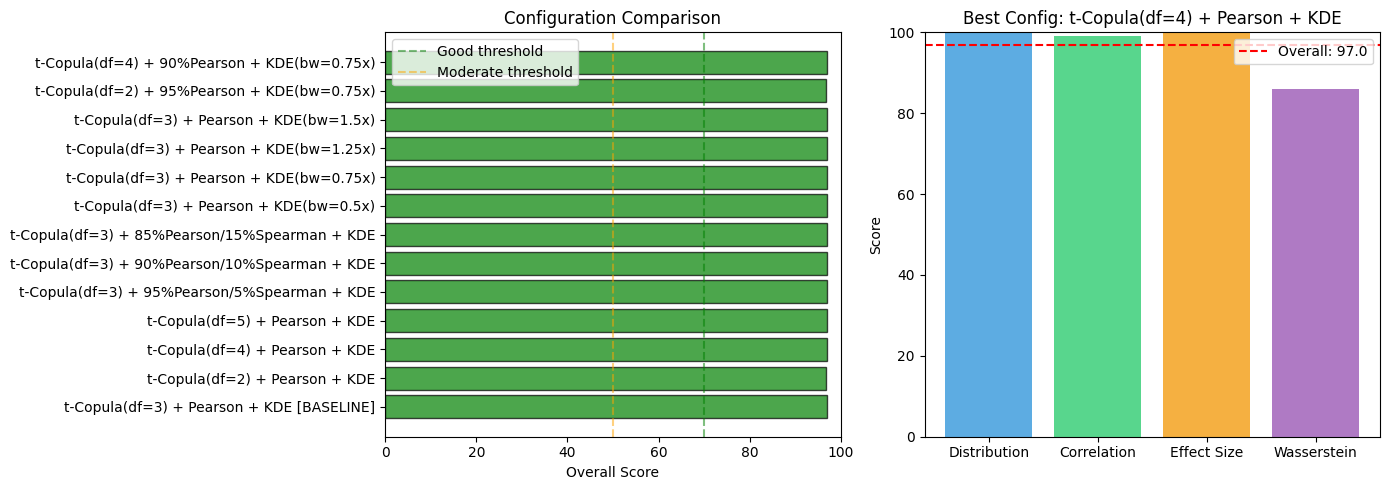

In [14]:
# =============================================================================
# VISUALIZATION: CONFIGURATION COMPARISON
# =============================================================================

if results_list:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of scores
    names = [r['name'] for r in results_list]
    scores = [r['score'] for r in results_list]
    
    colors = ['green' if s >= 70 else 'orange' if s >= 50 else 'red' for s in scores]
    
    ax1 = axes[0]
    bars = ax1.barh(names, scores, color=colors, alpha=0.7, edgecolor='black')
    ax1.axvline(x=70, color='green', linestyle='--', alpha=0.5, label='Good threshold')
    ax1.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Moderate threshold')
    ax1.set_xlabel('Overall Score')
    ax1.set_title('Configuration Comparison')
    ax1.set_xlim(0, 100)
    ax1.legend()
    
    # Component breakdown for best
    ax2 = axes[1]
    components = ['Distribution', 'Correlation', 'Effect Size', 'Wasserstein']
    values = [
        best_eval['distribution_score'],
        best_eval['correlation_score'],
        best_eval['effect_score'],
        best_eval['wasserstein_score']
    ]
    
    bars2 = ax2.bar(components, values, color=['#3498db', '#2ecc71', '#f39c12', '#9b59b6'], alpha=0.8)
    ax2.axhline(y=best_eval['overall_score'], color='red', linestyle='--', label=f'Overall: {best_eval["overall_score"]:.1f}')
    ax2.set_ylabel('Score')
    ax2.set_title(f'Best Config: {best["name"]}')
    ax2.set_ylim(0, 100)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'enhanced_copula_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

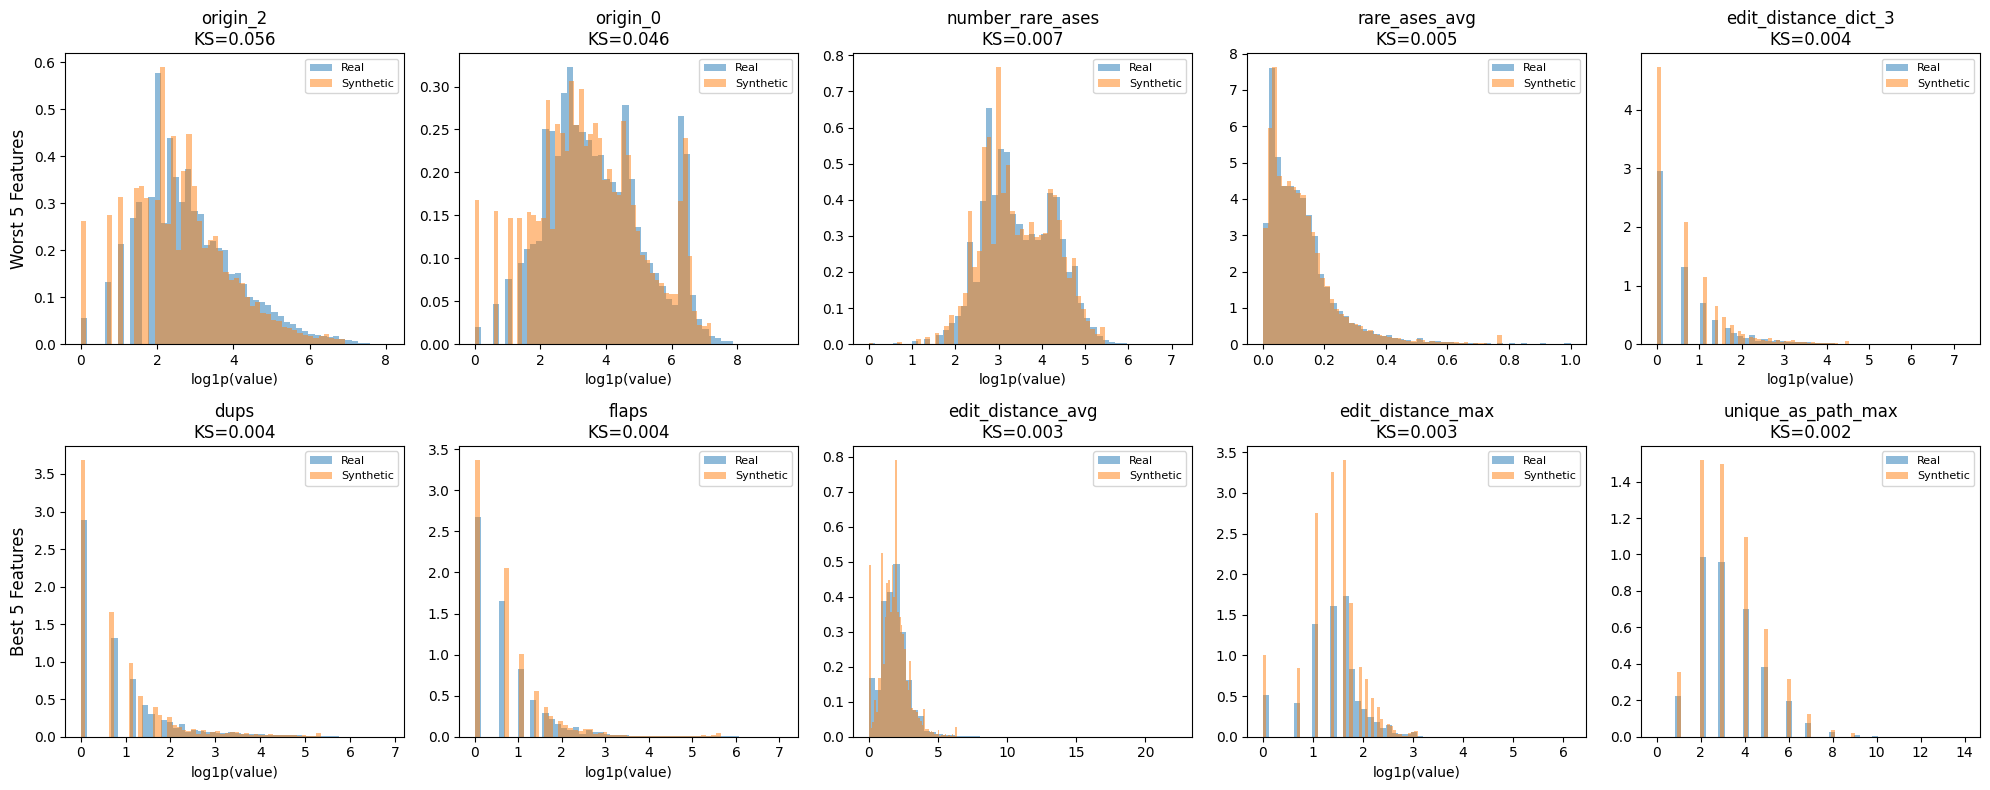

In [15]:
# =============================================================================
# VISUALIZATION: DISTRIBUTION COMPARISON
# =============================================================================

if results_list:
    # Get worst features by KS
    ks_sorted = sorted(best_eval['ks_stats'].items(), key=lambda x: x[1], reverse=True)
    worst_5 = [f for f, _ in ks_sorted[:5]]
    best_5 = [f for f, _ in ks_sorted[-5:]]
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    # Worst features
    for idx, feat in enumerate(worst_5):
        ax = axes[0, idx]
        real_vals = X_real[feat].values
        syn_vals = best_synthetic[feat].values
        
        # Log scale if needed
        if real_vals.max() > 100:
            real_vals = np.log1p(real_vals)
            syn_vals = np.log1p(syn_vals)
            ax.set_xlabel('log1p(value)')
        
        ax.hist(real_vals, bins=50, alpha=0.5, label='Real', density=True)
        ax.hist(syn_vals, bins=50, alpha=0.5, label='Synthetic', density=True)
        ax.set_title(f'{feat}\nKS={best_eval["ks_stats"][feat]:.3f}')
        ax.legend(fontsize=8)
    
    # Best features
    for idx, feat in enumerate(best_5):
        ax = axes[1, idx]
        real_vals = X_real[feat].values
        syn_vals = best_synthetic[feat].values
        
        if real_vals.max() > 100:
            real_vals = np.log1p(real_vals)
            syn_vals = np.log1p(syn_vals)
            ax.set_xlabel('log1p(value)')
        
        ax.hist(real_vals, bins=50, alpha=0.5, label='Real', density=True)
        ax.hist(syn_vals, bins=50, alpha=0.5, label='Synthetic', density=True)
        ax.set_title(f'{feat}\nKS={best_eval["ks_stats"][feat]:.3f}')
        ax.legend(fontsize=8)
    
    axes[0, 0].set_ylabel('Worst 5 Features', fontsize=12)
    axes[1, 0].set_ylabel('Best 5 Features', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'enhanced_copula_distributions.png'), dpi=150, bbox_inches='tight')
    plt.show()

## 9. Save Results

In [ ]:
# =============================================================================
# PREPARE AND SAVE FINAL OUTPUT
# =============================================================================

if results_list:
    # Prepare final output
    synthetic_final = best_synthetic.copy()
    
    # Convert to integers
    for col in synthetic_final.columns:
        if col in INTEGER_FEATURES:
            synthetic_final[col] = synthetic_final[col].fillna(0).astype(int)
    
    # Add metadata columns
    #synthetic_final.insert(0, 'sequence_id', range(len(synthetic_final)))
    synthetic_final.insert(0, 'timestamp', pd.date_range('2024-01-01', periods=len(synthetic_final), freq='1min'))
    synthetic_final['label'] = 'normal'
    
    # Save
    output_path = os.path.join(OUTPUT_DIR, 'synthetic_enhanced_copula.csv')
    synthetic_final.to_csv(output_path, index=False)
    
    print(f"Saved to: {output_path}")
    print(f"Shape: {synthetic_final.shape}")
    print(f"Columns: {list(synthetic_final.columns)}")
    print(f"\nFirst few rows:")
    synthetic_final.head()

Saved to: /home/smotaali/BGP_Traffic_Generation/results/Copula_v3/synthetic_enhanced_copula.csv
Shape: (60000, 30)
Columns: ['sequence_id', 'timestamp', 'announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps', 'label']

First few rows:


In [17]:
# =============================================================================
# SAVE EVALUATION RESULTS
# =============================================================================

import json

if results_list:
    eval_output = {
        'best_config': best['name'],
        'overall_score': best_eval['overall_score'],
        'component_scores': {
            'distribution': best_eval['distribution_score'],
            'correlation': best_eval['correlation_score'],
            'effect_size': best_eval['effect_score'],
            'wasserstein': best_eval['wasserstein_score']
        },
        'mean_ks': best_eval['mean_ks'],
        'structure_corr': best_eval['structure_corr'],
        'good_features_count': best_eval['good_features'],
        'effect_counts': best_eval['effect_counts'],
        'all_configs_tested': [
            {'name': r['name'], 'score': r['score']} for r in results_list
        ],
        'n_samples': N_SYNTHETIC,
        'n_features': best_eval['n_features']
    }
    
    eval_path = os.path.join(OUTPUT_DIR, 'enhanced_copula_evaluation.json')
    with open(eval_path, 'w') as f:
        json.dump(eval_output, f, indent=2)
    
    print(f"Evaluation saved to: {eval_path}")

Evaluation saved to: /home/smotaali/BGP_Traffic_Generation/results/Copula_v3/enhanced_copula_evaluation.json


In [18]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

if results_list:
    print("="*70)
    print("ENHANCED COPULA GENERATION COMPLETE")
    print("="*70)
    print(f"\nBest Configuration: {best['name']}")
    print(f"Overall Score: {best_eval['overall_score']:.1f}/100")
    print(f"\nComponent Scores:")
    print(f"  - Distribution (KS < 0.1): {best_eval['distribution_score']:.1f}/100")
    print(f"  - Correlation Structure: {best_eval['correlation_score']:.1f}/100")
    print(f"  - Effect Size: {best_eval['effect_score']:.1f}/100")
    print(f"  - Wasserstein Distance: {best_eval['wasserstein_score']:.1f}/100")
    print(f"\nOutput saved to: {output_path}")
    print("="*70)

ENHANCED COPULA GENERATION COMPLETE

Best Configuration: t-Copula(df=4) + Pearson + KDE
Overall Score: 97.0/100

Component Scores:
  - Distribution (KS < 0.1): 100.0/100
  - Correlation Structure: 99.2/100
  - Effect Size: 100.0/100
  - Wasserstein Distance: 86.0/100

Output saved to: /home/smotaali/BGP_Traffic_Generation/results/Copula_v3/synthetic_enhanced_copula.csv
